In [1]:
import torch
from numpy.ma.core import size
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from model import FFN
from data_reader import SingleImageDataset
from INR_pos_encod import pose_encod

In [2]:
img_path = r'data/'

In [3]:
device = ("cuda"
      if torch.cuda.is_available()
      else "mps"
      if torch.backends.mps.is_available()
      else "cpu")

print(f"Using {device} device")

Using cuda device


In [4]:
lr = 1e-4
b_size = 128

m = 100
B = 10 * torch.randn(m, 2).to(device)

In [5]:
net = FFN(input_dim=2 * m).to(device)

dataset = SingleImageDataset(img_path + 'image.png')
dataloader = DataLoader(dataset, batch_size=b_size, shuffle=False)

# We are training the network for pixels,
# so will do a pixelwise MSE loss
criterion = torch.nn.MSELoss()

# Optimizer and number of epochs
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
NUM_EPOCHS = 1000

In [6]:
loss_values = []

# train and store loss values
for epoch in range(NUM_EPOCHS):
  for batch in dataloader:
    x, y, actual = batch["x"], batch["y"], batch["intensity"]
    x = x / dataset.w # normalizing x between 0 and 1
    y = y / dataset.h # normalizing y between 0 and 1
      
    coord = torch.stack((x, y), dim=-1).to(device)
      
    pose_coord = pose_encod(B, coord)
      
    ### Assemble coord from x and y, pass to net, compute loss
    pred = net(pose_coord)
    loss = criterion(pred, actual.float().to(device))
      
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # Track loss
  loss_values.append(loss.item())
  avg_loss = sum(loss_values) / len(loss_values)
  print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}], Loss: {avg_loss}")
  
torch.save(net.state_dict(), img_path+'pos_encode_model.pt')


Epoch [1/1000], Loss: 0.006749784108251333
Epoch [2/1000], Loss: 0.007940791314467788
Epoch [3/1000], Loss: 0.008267460856586695
Epoch [4/1000], Loss: 0.007713837316259742
Epoch [5/1000], Loss: 0.007689586747437716
Epoch [6/1000], Loss: 0.007271112563709418
Epoch [7/1000], Loss: 0.007037436123937368
Epoch [8/1000], Loss: 0.007210041920188814
Epoch [9/1000], Loss: 0.006944540836330917
Epoch [10/1000], Loss: 0.00666289571672678
Epoch [11/1000], Loss: 0.006490978369997306
Epoch [12/1000], Loss: 0.006337030286279817
Epoch [13/1000], Loss: 0.006218707403884484
Epoch [14/1000], Loss: 0.005994067128215518
Epoch [15/1000], Loss: 0.006030800814429919
Epoch [16/1000], Loss: 0.00585571960255038
Epoch [17/1000], Loss: 0.005769015413106364
Epoch [18/1000], Loss: 0.005681312655926579
Epoch [19/1000], Loss: 0.005518713818961068
Epoch [20/1000], Loss: 0.00546842934563756
Epoch [21/1000], Loss: 0.005306854433867903
Epoch [22/1000], Loss: 0.0053642918038266625
Epoch [23/1000], Loss: 0.005381536518183091

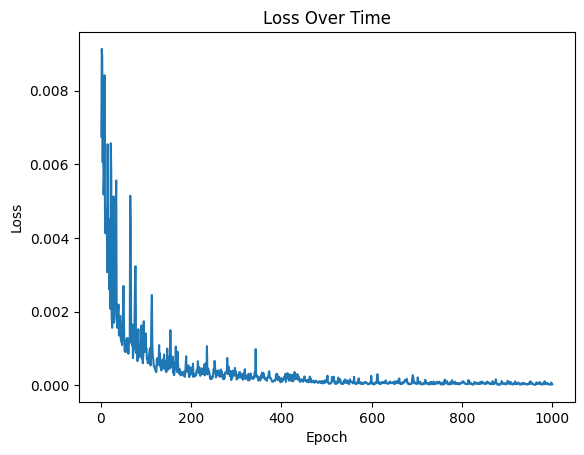

In [7]:
plt.plot(range(1, NUM_EPOCHS + 1), loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Time')
plt.show()
